In [11]:
import yfinance as yf
import random
import numpy as np
import pandas as pd


class PriceLoader:
    def __init__(self, ticker: str, start: str, end: str):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.prices = []

    def fetch_prices(self):
        data = yf.download(self.ticker, start=self.start, end=self.end)
        self.prices = data["Close"].values.tolist()
        return self.prices


class Strategy:
    def generate_signals(self, prices: list) -> list:
        raise NotImplementedError("Must implement generate_signals")


class RandomWalkStrategy(Strategy):
    def generate_signals(self, prices: list) -> list:
        return [random.choice([1, -1, 0]) for _ in prices]


class StaticLongStrategy(Strategy):
    def generate_signals(self, prices: list) -> list:
        return [1] + [0] * (len(prices) - 1)


class MovingAverageStrategy(Strategy):
    def __init__(self, short_window=20, long_window=50):
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self, prices: list) -> list:
        signals = []
        for i in range(len(prices)):
            if i < self.long_window:
                signals.append(0)
                continue
            short_ma = sum(prices[i - self.short_window : i][0]) / self.short_window
            long_ma = sum(prices[i - self.long_window : i][0]) / self.long_window
            if short_ma > long_ma:
                signals.append(1)
            elif short_ma < long_ma:
                signals.append(-1)
            else:
                signals.append(0)
        return signals


class TradeSimulator:
    def __init__(self, initial_cash=10000):
        self.cash = initial_cash
        self.position = 0
        self.portfolio_values = []

    def run(self, prices: list, signals: list):
        for i in range(1, len(prices)):
            signal = signals[i - 1]  # act on previous day's signal
            price = prices[i][0]
            if signal == 1:  # BUY
                self.cash -= price
                self.position += 1
            elif signal == -1 and self.position > 0:  # SELL
                self.cash += price
                self.position -= 1
            # HOLD does nothing
            portfolio_value = self.cash + self.position * price
            self.portfolio_values.append(portfolio_value)


prices = PriceLoader("AAPL", "2008-01-01", "2025-01-01").fetch_prices()
MAstrategy = MovingAverageStrategy(short_window=20, long_window=50)
signals = MAstrategy.generate_signals(prices)

simulator = TradeSimulator(initial_cash=10000)
simulator.run(prices, signals)
print(
    f"The final value of the portfolio using the Simple Moving Average strat is: ${simulator.portfolio_values[-1]:.2f}"
)
RWs = RandomWalkStrategy()
signals2 = RWs.generate_signals(prices = prices)
simulator2 = TradeSimulator(initial_cash=10000)
simulator2.run(prices, signals2)
print(
    f"The final value of the portfolio using the Random Walk strat is: ${simulator2.portfolio_values[-1]:.2f}"
)

SWs = StaticLongStrategy()
signals3 = SWs.generate_signals(prices = prices)
simulator3 = TradeSimulator(initial_cash=10000)
simulator3.run(prices, signals3)
print(
    f"The final value of the portfolio using the Static Long strat is: ${simulator3.portfolio_values[-1]:.2f}"
)


/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_18927/4002763809.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.ticker, start=self.start, end=self.end)
[*********************100%***********************]  1 of 1 completed

The final value of the portfolio using the Simple Moving Average strat is: $808850.40
The final value of the portfolio using the Random Walk strat is: $11419.53
The final value of the portfolio using the Static Long strat is: $10243.68


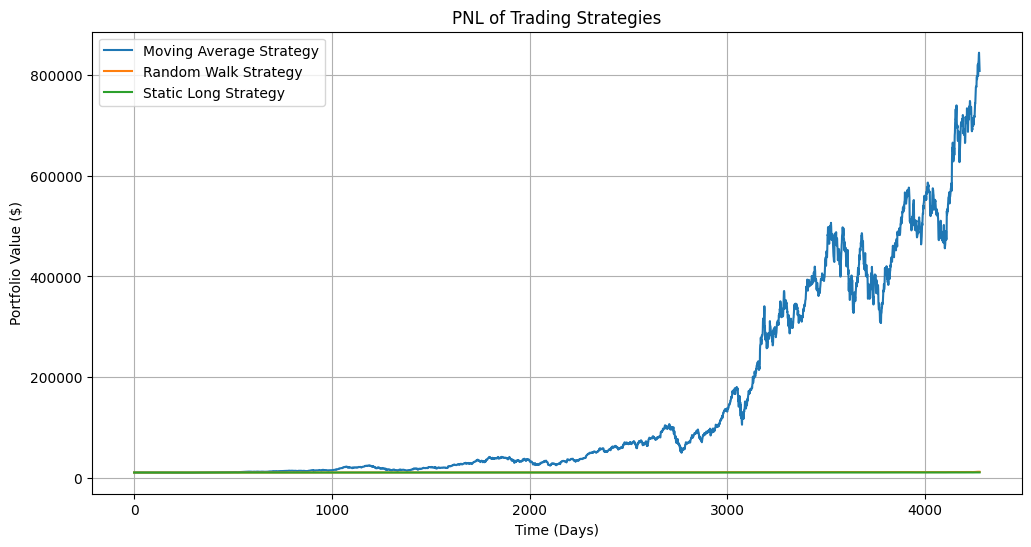

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(simulator.portfolio_values, label="Moving Average Strategy")
plt.plot(simulator2.portfolio_values, label="Random Walk Strategy")
plt.plot(simulator3.portfolio_values, label="Static Long Strategy")
plt.title("PNL of Trading Strategies")
plt.xlabel("Time (Days)")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

# Results
### Because we can now have a quantity of more than 1 the moving average does the best. This is because the Static long still only buys 1 share, while MA buys many. Unsurprisngly, random still sucks. 